# 残差网络 ResNet

源于一个思想 加深神经网络一定能改进精度吗

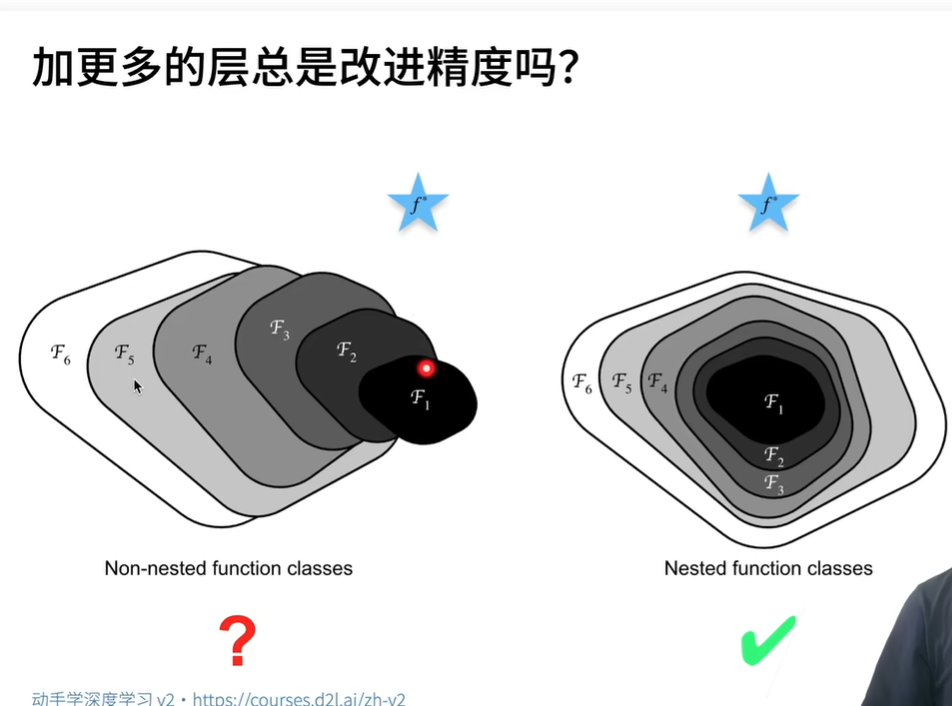


# 不一定

ResNet想到的方法进行嵌套函数
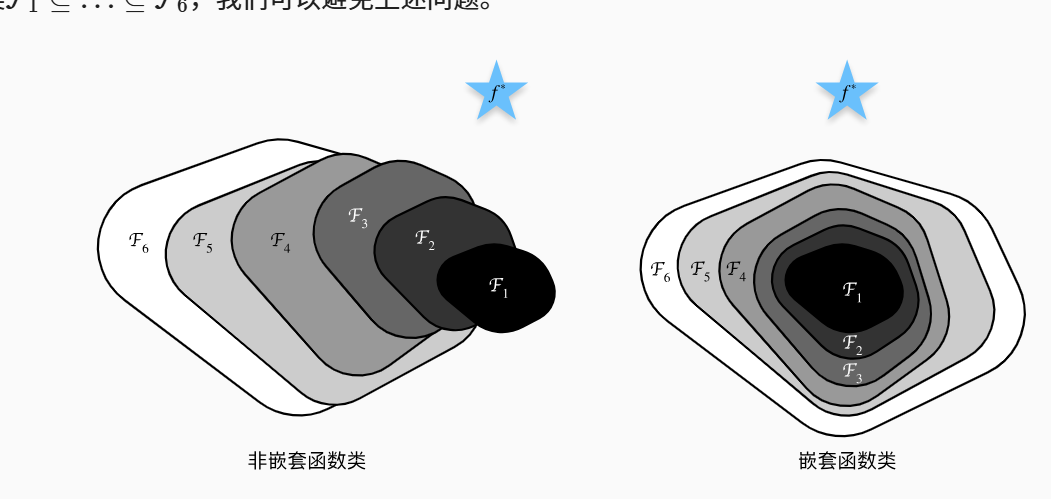

残差网络的核心思想是：每个附加层都应该更容易地包含原始函数作为其元素之一。 于是，残差块（residual blocks）便诞生了，这个设计对如何建立深层神经网络产生了深远的影响。

# 残差块

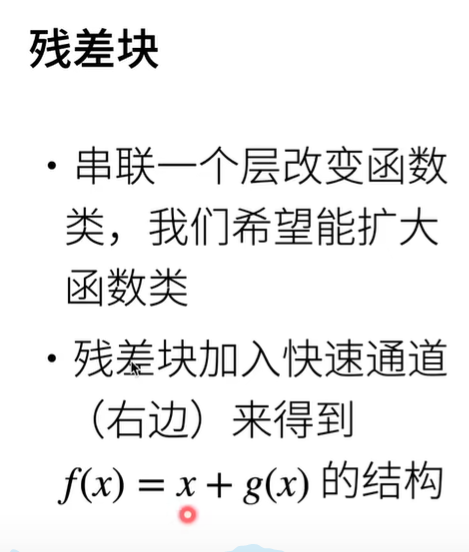

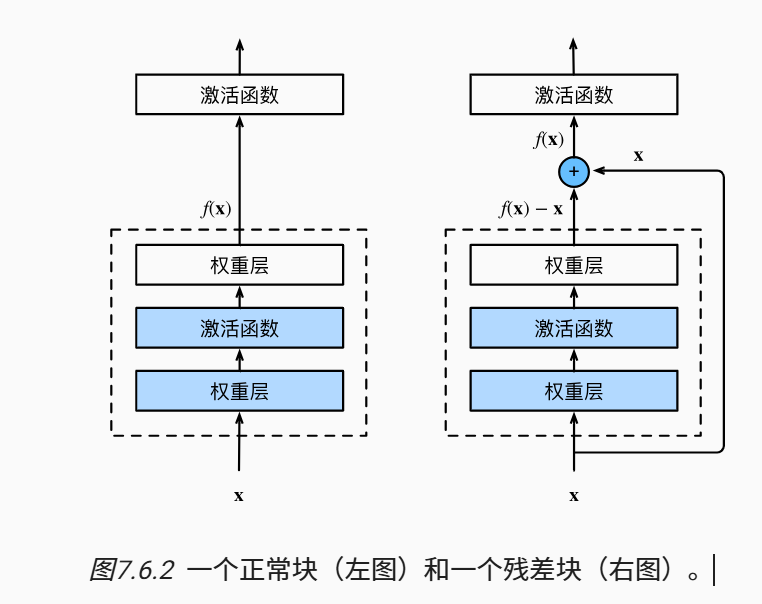

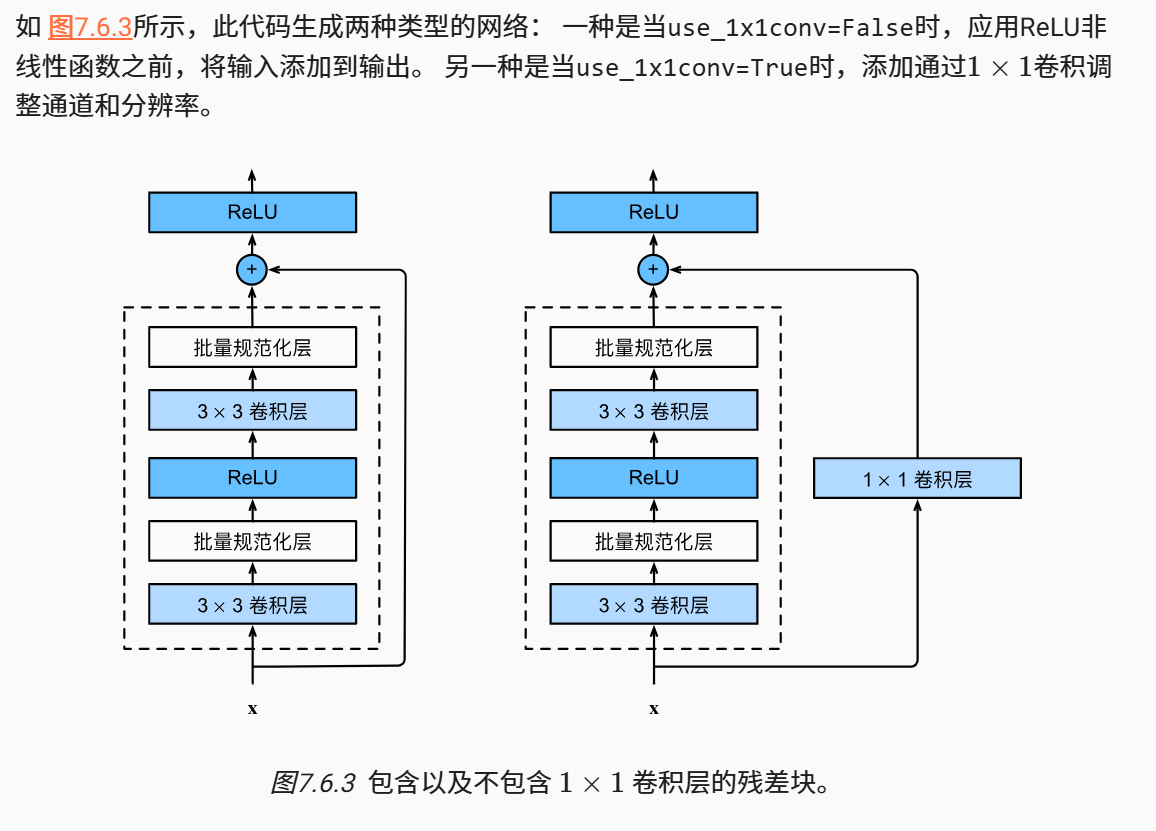

# 也可以尝试使用不同的残差块

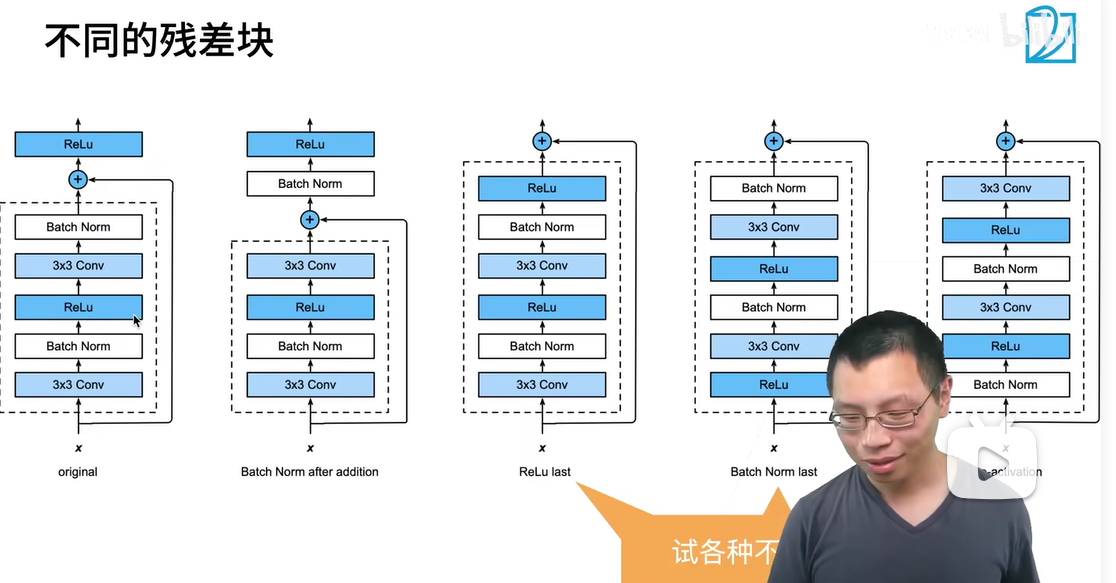

# ResNet块

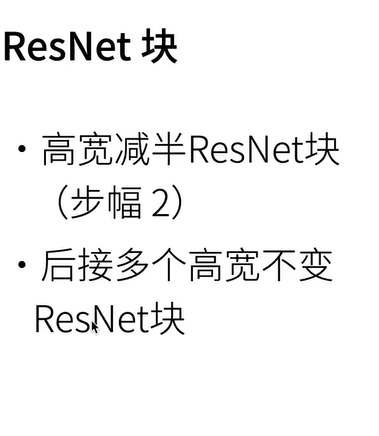

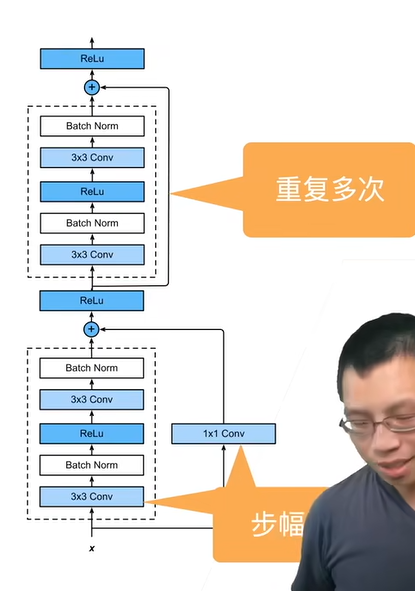

# 不同esNet块的组合可以得到不同的ResNet架构
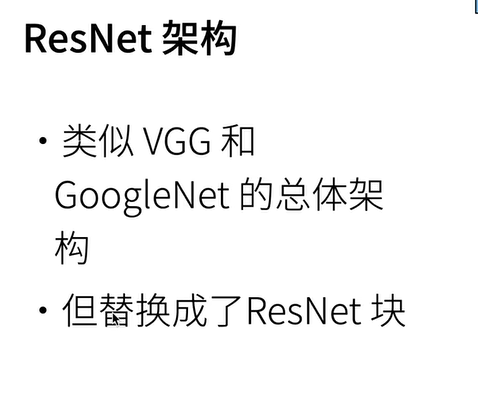

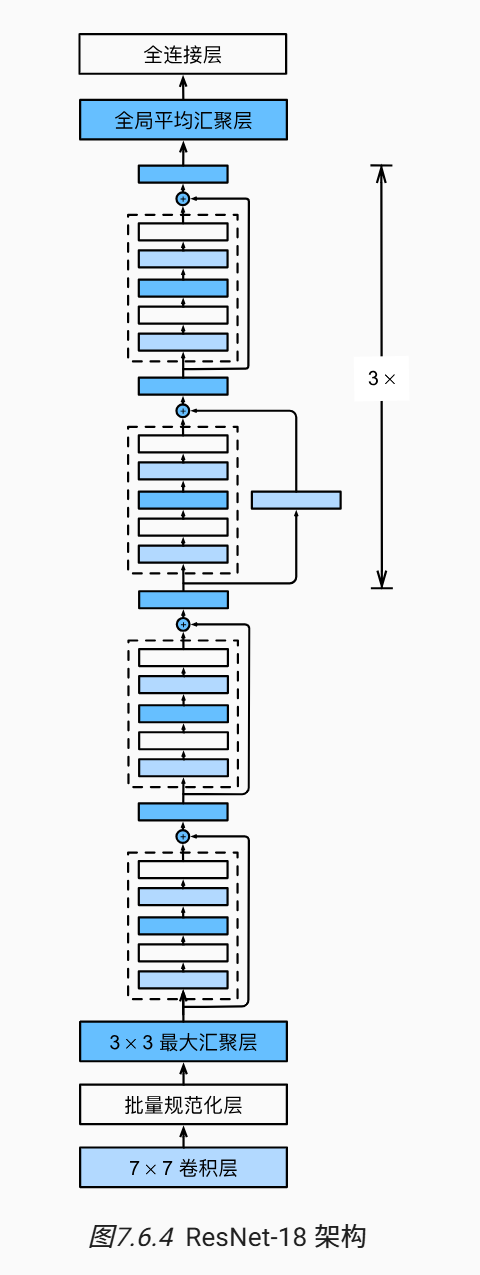

# ResNet进行了持续的改进

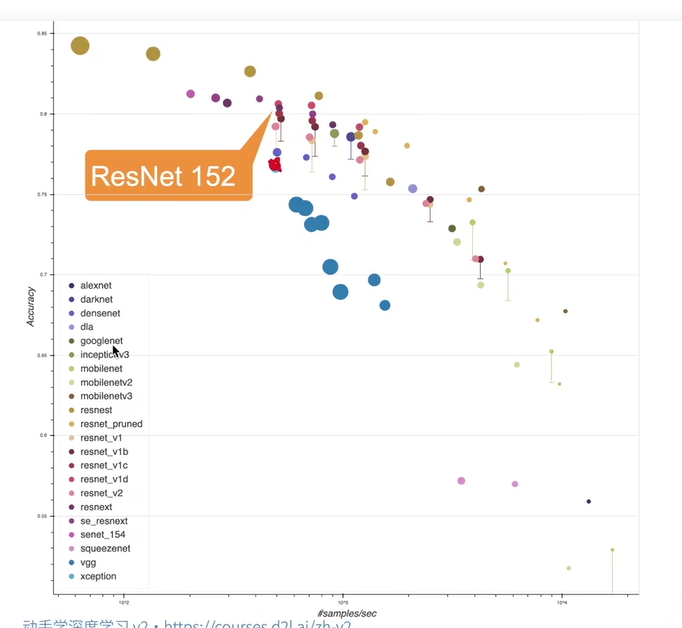

残差块（Residual Block）是一种常用于深度神经网络中的构建模块，特别是在解决梯度消失（vanishing gradient）和梯度爆炸（exploding gradient）问题时非常有效。它最初由Kaiming He等人在提出的残差网络（ResNet）中引入，并被广泛应用于各种深度学习任务中。

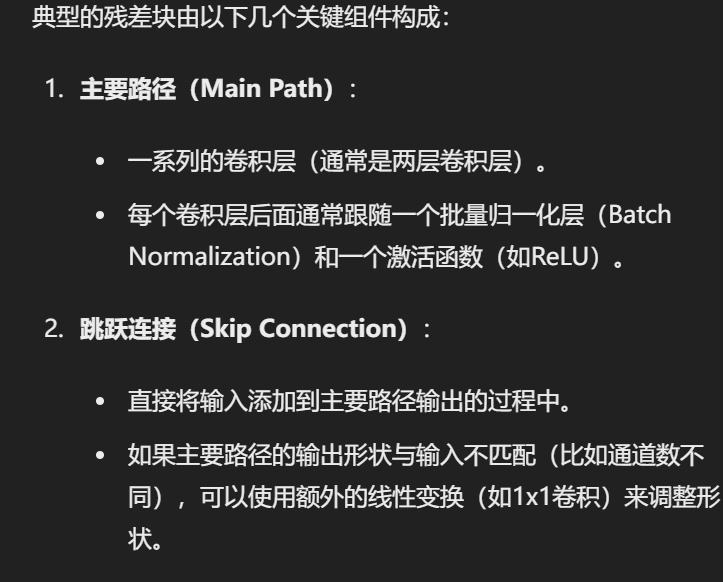

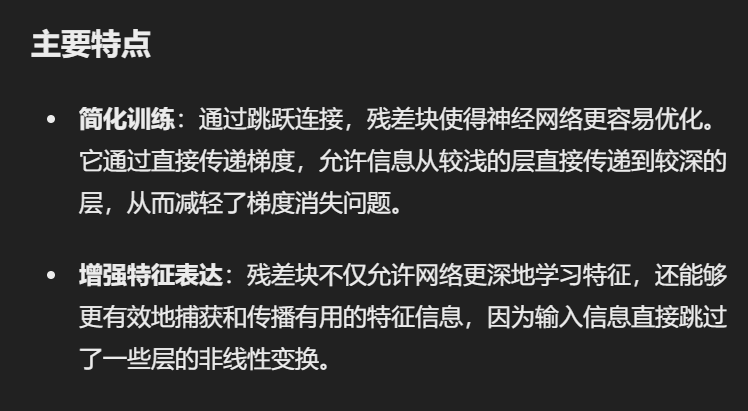

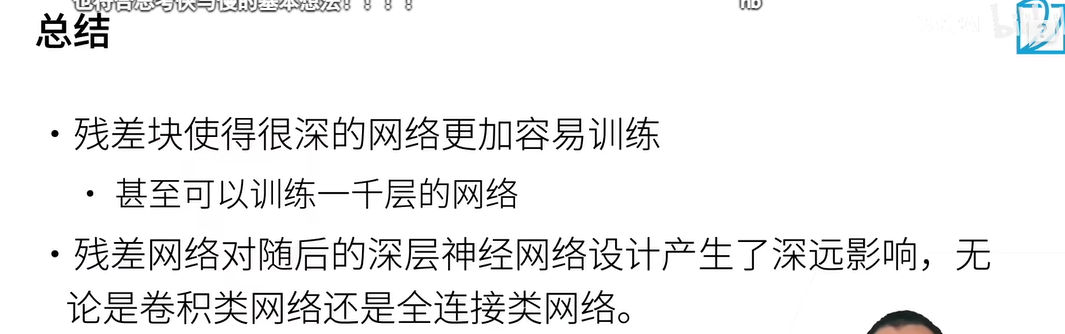

In [1]:
# 残差块的实现 构建深度神经网络中的残差连接

import torch
from torch import nn
from torch.nn import functional as F

class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        
        super().__init__()
        # 第一个卷积层，3x3卷积核，padding=1保持特征图大小，strides控制步长
        self.conv1 = nn.Conv2d(input_channels, num_channels, 
                               kernel_size=3, padding=1, stride=strides)
        # 第二个卷积层，3x3卷积核，padding=1保持特征图大小
        self.conv2 = nn.Conv2d(num_channels, num_channels, 
                               kernel_size=3, padding=1)
        
        # 如果使用了1x1卷积，则用于调整输入的通道数，使其与卷积核输出通道数一致
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        
        # 批量归一化层，对卷积输出进行归一化，提高训练效果和速度
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        # 激活函数Relu后，应用第一个卷积层和批量归一化层
        Y = F.relu(self.bn1(self.conv1(X)))
        # 应用第二个卷积层和批量归一化层
        Y = self.bn2(self.conv2(Y))
        
        # 如果使用了1x1卷积，则将输入调整为与卷积核输出通道数相同
        if self.conv3:
            X = self.conv3(X)
        
        # 残差块的关键步骤，将卷积输出与输入相加，然后再次应用激活函数Relu
        Y += X
        return F.relu(Y)

In [3]:
# 验证一下
# 创建一个残差块
blk = Residual(3,3) #输入通道是3 输出通道也是3
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

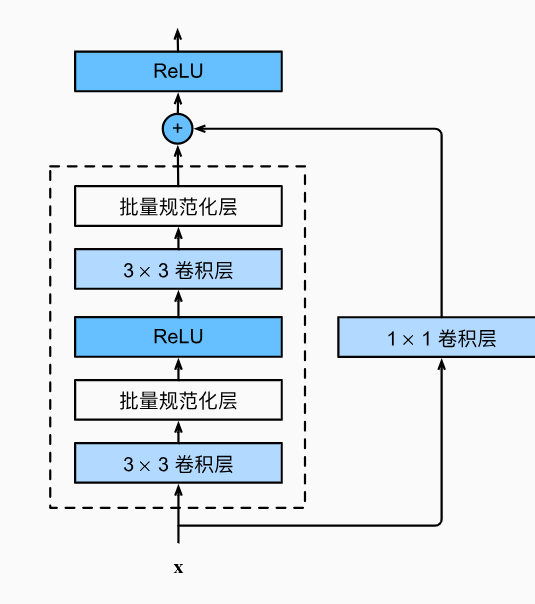

In [4]:
#我们也可以在增加输出通道数的同时，减半输出的高和宽 使用了1x1的卷积核
blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

In [5]:
# 实现一个ResNet模型

# ResNet则使用4个由残差块组成的模块，每个模块使用若干个同样输出通道数的残差块

#一个卷积层+一个归一化+一个Relu+一个max池化层
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

# input_channels: 输入通道数。
# num_channels: 每个残差块中卷积层的输出通道数。
# num_residuals: 残差块的数量。
# first_block: 布尔值，指示是否是第一个残差块。

#循环创建残差块

def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

#b2残差块不会减半
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [7]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), 
                    nn.Linear(512, 10))

In [8]:
X = torch.rand(size=(1, 1, 224, 224)) #假设是224x224且一个通道的话
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)
    


Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


loss 0.016, train acc 0.995, test acc 0.919
2831.5 examples/sec on cuda:0


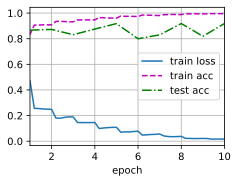

In [9]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

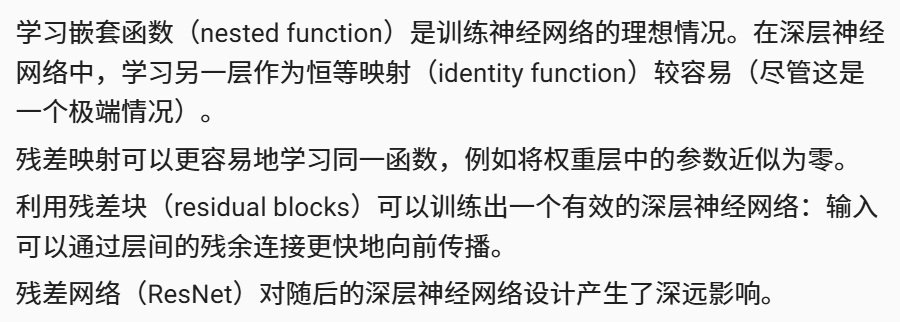

# ResNet为什么能训练出1000层的模型
如何避免梯度消失？越来越深的网络会使得梯度在越靠近下面的值大幅下降
靠近数据端的权重 w 难以训练


将乘法运算变成加法运算（ResNet就是这么做的，特别是残差连接（Residual Connection））

避免梯度消失 可以是将乘法变成加法

计算梯度的过程（ResNet的方法绿色）

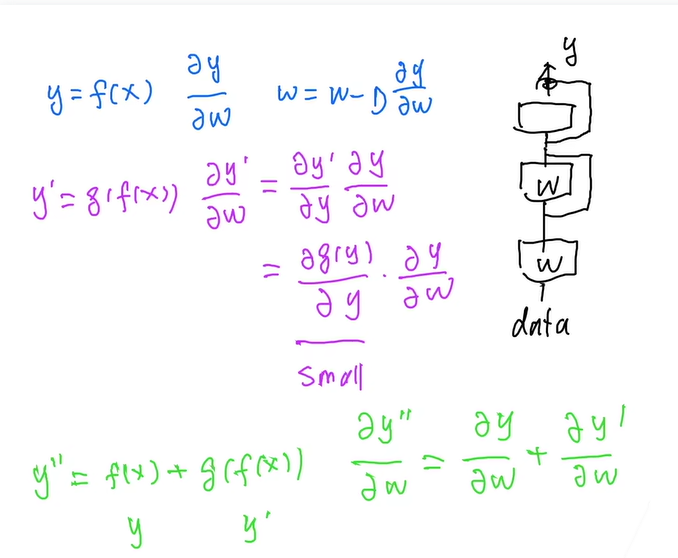

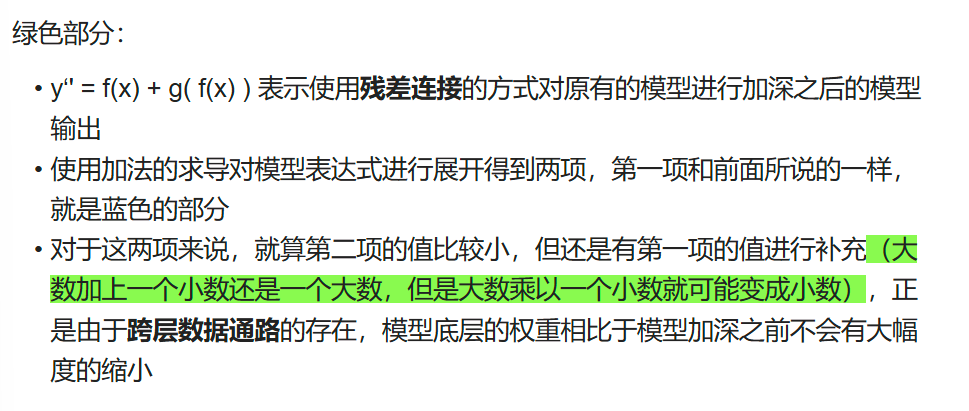

但是由于加入了跨层数据通路，所以在计算梯度的时候，上层的loss可以通过跨层连接通路直接快速地传递给下层，所以在一开始，下面的层也能够拿到比较大的梯度 